# Web APIs & Classification

## Project Challenge Statement

### Goal: 
#### 1. Using Reddit's API, collect posts from two subreddits: AskWomen, AskMen 
#### 2. NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

---

### Datasets: 
1. AskMen vs AskWomen (0, 1)

---

### Model Improvement
Use all baseline models with gridsearch parameters in the previous notebook to build ensemble model. 

---

### Ensemble Model 
- with CountVectorizer 
- with TFIDF Model
- with Logistic Regression 
- with Multinomial NB
- with RandomForestClassifier
- with ExtraTreesClassifier
- with AdaBoostClassifier
- with SVM

---

### Notebook Walkthrough 
1. Build ensemble model 
    - `AskMen:0, AskWomen:1`
2. Evaluate model 
3. Plot keywords with highest coefficients 
4. Switch targets
    - `Askmen:1, AskWomen:0`
5. Build ensemble model with switched target 
6. Evaluate model 
7. Plot keywords with highest coefficients 

---

## Table of Contents 

This Notebook is broken down into different sections for analysis purpose. The following links are connected to differenct section within the Notebook for simple navigation. 

### Contents:
- [Ensamble Model With Best Parameters](#Ensamble-Model-With-Best-Parameters)
    - [Ensemble Model 1: With menwomen_df](#Ensemble-Model-1:-With-menwomen_df)
    - [Model1 Evaluation](#Model1-Evaluation)
    - [Extracting Keywords Coefficients](#Extracting-Keywords-Coefficients)
    - [Words-EDA](#Words-EDA)
    - [Visualizing Words With Highest Coefficients](#Visualizing-Words-With-Highest-Coefficients)
- [Model-With-Target-Switched](#Model-With-Target-Switched)
    - [Ensemble-Model-2:-With-menwomen_df](#Ensemble-Model-2:-With-menwomen_df)
    - [Model2-Evaluation](#Model2-Evaluation)
    - [Extracting-Keywords-Coefficients](#Extracting-Keywords-Coefficients)
    - [Visualizing Words With Highest Coefficients](#Visualizing-Words-With-Highest-Coefficients)
    
    
---

In [9]:
# !pip install pactools
import warnings
warnings.filterwarnings('ignore')

In [32]:
import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

In [33]:
menwomen_df = pd.read_csv('../data/AskMenAskWomen.csv')
menwomen_df = menwomen_df.drop(columns = 'Unnamed: 0')

### Train Test Split Data

In [34]:
#train-test-split 
X = menwomen_df["Title_Content"]
y = menwomen_df['Subreddit']

#Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

# Ensamble Model With Best Parameters 

## Ensemble Model 1: With menwomen_df

In [35]:
# models with Best Parameters from previous notebook
mnb = MultinomialNB()
logit = LogisticRegression()
rf = RandomForestClassifier(max_depth = 100, 
                            min_samples_leaf= 2, 
                           n_estimators= 100)
et = ExtraTreesClassifier( max_depth = 50, 
                           min_samples_leaf = 2, 
                           n_estimators = 100)
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth = 50), 
                         learning_rate = 1.0, 
                         n_estimators = 200)
svc = svm.SVC(C= 1.5, kernel= 'rbf')

In [36]:
#building votingclassifier model 
#will be apply to the rest of the model
vc = VotingClassifier(estimators= [('mnb', mnb),
                                   ('logit', logit),
                                   ('rf', rf), 
                                   ('et', et), 
                                   ('ada', ada), 
                                   ('svc', svc)], 
                     voting = 'hard')

In [37]:
#building Pipeline
pipe1 = Pipeline([
#      ('cvec1', CountVectorizer(max_df= 0.95, 
#                        max_features= 1500, 
#                        min_df= 2, 
#                        ngram_range= (1,1))),  
    
#     ( 'cvec2 ', CountVectorizer(max_df= 0.95, 
#                        max_features= 1000, 
#                        min_df= 2, 
#                        stop_words = 'english',
#                        ngram_range= (1,1))), 
    
#     ('tfidf1', TfidfVectorizer(max_df= 0.95,  
#                        max_features= 1000, 
#                        min_df= 5, 
#                        ngram_range= (1,1))),
    
    ('tfidf2', TfidfVectorizer(max_df= 0.95,
                       max_features= 1500, 
                       min_df= 2, 
                       ngram_range= (1,2))),
    
    ('vc', vc)
])

In [38]:
#checking baseline CrossValidation Score 
cross_val_score(pipe1, X_train, y_train, cv = 10).mean()

0.743528103812787

In [39]:
pipe1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf2', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1500, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru....001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None))])

In [40]:
print('train score', pipe1.score(X_train, y_train))
print('test score', pipe1.score(X_test, y_test))

train score 0.9129438717067583
test score 0.7253333333333334


In [41]:
#make prediction 
predict = pipe1.predict(X_train)

In [42]:
#make test prediction 
test_prediction = pipe1.predict(X_test)

## Model1 Evaluation 

### Train Confusion Matrix 

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
confusion_matrix(y_true= y_train, y_pred= predict)

array([[293,  74],
       [  2, 504]])

In [45]:
tn, fp, fn, tp = confusion_matrix(y_true= y_train, y_pred= predict).ravel()
(tn, fp, fn, tp)

(293, 74, 2, 504)

In [46]:
#precision 
tp/(tp+fp)

0.8719723183391004

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, predict)

0.8972062767229217

### Test Confusion Matrix 

In [48]:
confusion_matrix(y_true= y_test, y_pred= test_prediction)

array([[ 75,  83],
       [ 20, 197]])

In [49]:
tn, fp, fn, tp = confusion_matrix(y_true= y_test, y_pred= test_prediction).ravel()
(tn, fp, fn, tp)

(75, 83, 20, 197)

In [50]:
#precision 
tp/(tp+fp)

0.7035714285714286

In [116]:
(75+197)/(75+83+20+197)

0.7253333333333334

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, test_prediction)

0.6912588228431429

## Extracting Keywords Coefficients 

In [52]:
pipe1.named_steps['vc'].estimators_

[MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=100, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2

In [53]:
mnb_coef = pipe1.named_steps['vc'].estimators_[0].coef_[0]

#saving logistic coefficient 
logit_coef = pipe1.named_steps['vc'].estimators_[1].coef_[0]

In [54]:
#get column names 
tfidf = TfidfVectorizer(max_df= 0.95, 
                       max_features= 1500, 
                       min_df= 2, 
                       ngram_range= (1,2))
X_train_tfidf = tfidf.fit_transform(X_train)

#Saving column name
col_name = tfidf.get_feature_names()
len(col_name)

1500

In [55]:
#Transforming Data to array
X_train_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.47603964,
        0.        ],
       [0.        , 0.        , 0.05049294, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.15711342, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [56]:
#turining counts into dataframe
word_count = pd.DataFrame(X_train_tfidf.toarray(), 
                       columns= col_name)

word_count.insert(0, 'Subreddit', y)
word_count.head()

,Subreddit,able,able to,about,about how,about it,about the,about this,about what,about your,...,your opinion,your parents,your partner,your period,your personal,your so,your story,your thoughts,yourself,youtube
0,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.47604,0.0
1,0,0.0,0.0,0.050493,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0
2,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0
3,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0
4,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.169062,0.0,0.0,0.00000,0.0


In [57]:
#Building relationship word dataframe 
word_count = word_count.groupby('Subreddit').sum().T

In [58]:
word_count.head()

Subreddit,0,1
able,1.126506,0.798880
able to,0.800866,0.756425
about,10.052586,7.193681
about how,0.446309,0.306689
about it,2.633626,0.877030


In [59]:
word_count.columns = ["AskMen", "AskWomen"]
word_count.to_csv('../data/AskMen0AskWomen1wordcount.csv')
word_count.head()

,AskMen,AskWomen
able,1.126506,0.798880
able to,0.800866,0.756425
about,10.052586,7.193681
about how,0.446309,0.306689
about it,2.633626,0.877030


In [60]:
menwomen_word = pd.DataFrame(data= [mnb_coef, logit_coef], columns= col_name, index= ['nb_coef', 'logit_coef'])
menwomen_word = menwomen_word.T
menwomen_word.to_csv('../data/AskMen0AskWomen1wordcoeff.csv')
menwomen_word.head()

,nb_coef,logit_coef
able,-7.643602,-0.079644
able to,-7.863674,-0.215020
about,-5.841216,-0.011452
about how,-7.959144,-0.012687
about it,-7.171521,-0.140483


In [61]:
menwomen_word.index.name = 'target'

## Words EDA 

In [62]:
menwomen_word.describe()

,nb_coef,logit_coef
count,1500.000000,1500.000000
mean,-7.532928,-0.051024
std,0.555139,0.283544
min,-8.179097,-2.685943
25%,-7.914549,-0.186547
50%,-7.645499,-0.035760
75%,-7.328544,0.096281
max,-4.382095,1.627263


In [63]:
menwomen_word.sort_values(by = 'nb_coef', ascending = True).head(20)

,nb_coef,logit_coef
target,,
guys who,-8.179097,-0.790965
for it,-8.179097,-0.088054
ask her,-8.179097,-0.059461
class,-8.179097,-0.131403
he is,-8.179097,-0.102100
whenever,-8.179097,-0.266105
gf,-8.179097,-0.519240
head,-8.179097,-0.496253
men of,-8.179097,-0.885945


In [64]:
menwomen_word.sort_values(by = 'logit_coef', ascending = False).head(20)

,nb_coef,logit_coef
target,,
ladies,-6.039852,1.627263
women,-5.870884,1.286027
your,-4.771480,1.163422
you have,-6.111311,1.104103
what,-4.635956,0.988478
do you,-5.090199,0.896632
you,-4.382095,0.890905
women who,-6.671499,0.820473
as,-6.193797,0.758852


In [69]:
#code reference Mark's NLP EDA notebook
top_words_nb = list(menwomen_word.groupby('target').mean().sort_values('nb_coef', ascending = False).head(20).index)
top_words_logit = list(menwomen_word.groupby('target').mean().sort_values('logit_coef', ascending = False).head(20).index)

In [70]:
top_words_nb[:8], top_words_logit[:8]

(['you', 'what', 'your', 'do', 'the', 'to', 'do you', 'how'],
 ['ladies', 'women', 'your', 'you have', 'what', 'do you', 'you', 'women who'])

## Visualizing Words With Highest Coefficients 

In [76]:
#extracting index to find word counts for Naive Base
#Coefficient from most negative
word_index = menwomen_word.sort_values(by = 'nb_coef', ascending = False).head(20).index
word_index

Index(['you', 'what', 'your', 'do', 'the', 'to', 'do you', 'how', 'and', 'of',
       'are', 'is', 'it', 'have', 'that', 'in', 'for', 'did', 'what are',
       'or'],
      dtype='object', name='target')

In [77]:
word_count.loc[word_index,]

,AskMen,AskWomen
target,,
you,40.694791,28.624296
what,31.534464,20.296435
your,26.823695,16.341694
do,23.625515,16.424676
the,29.164440,15.120878
to,29.553963,18.756743
do you,18.786654,13.083760
how,20.601487,14.023856
and,23.137510,15.862905


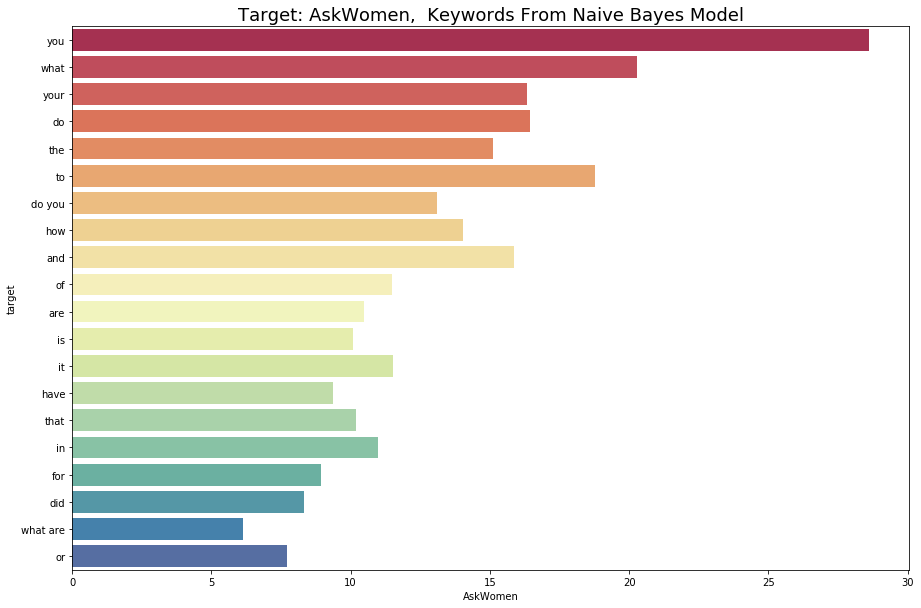

In [79]:
#plotting Naive Bayes Keyword coefficients from lowest to highest 
plt.figure(figsize = (15,10))
plt.title('Target: AskWomen,  Keywords From Naive Bayes Model', fontsize = 18)
sns.barplot(y = word_count.loc[word_index,].index, 
            x = word_count.loc[word_index,]['AskWomen'],
            palette="Spectral")
plt.savefig('../images/AskWomen_Keywords(NB).png')

In [80]:
#extracting index to find word counts for Logistic Regression
word_index2 = menwomen_word.sort_values(by = 'logit_coef', ascending = False).head(20).index
word_index2

Index(['ladies', 'women', 'your', 'you have', 'what', 'do you', 'you',
       'women who', 'as', 'people', 'experience', 'etc', 'ladies who', 'bad',
       'that you', 'you re', 'often do', 'you deal', 'ladies what',
       'you like'],
      dtype='object', name='target')

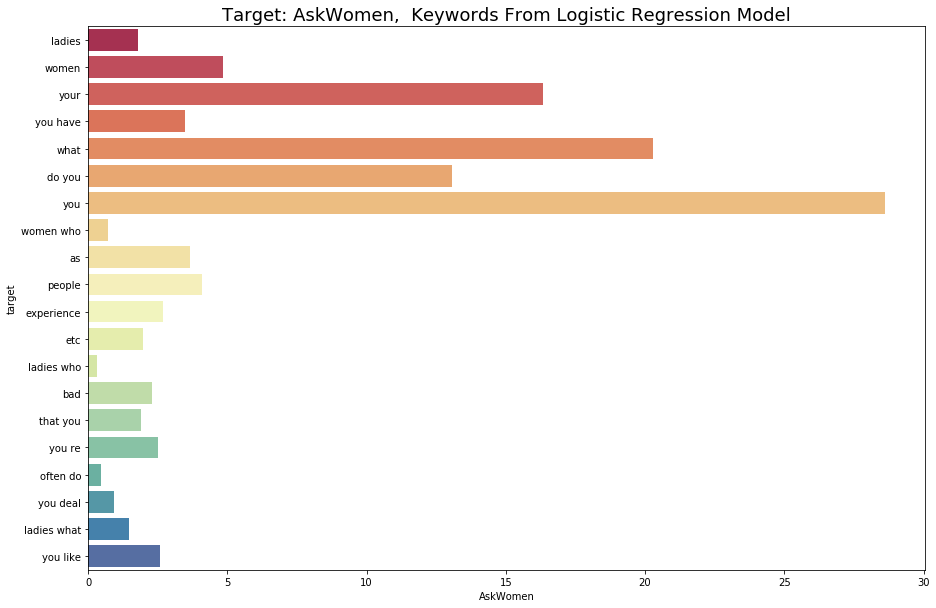

In [81]:
#plotting keywords with high coefficients 
plt.figure(figsize = (15,10))
plt.title('Target: AskWomen,  Keywords From Logistic Regression Model', fontsize = 18)
sns.barplot(y = word_count.loc[word_index2,].index, 
            x = word_count.loc[word_index2,]['AskWomen'],
            palette="Spectral")
plt.savefig('../images/AskWomen_Keywords(logreg).png')

# Model With Target Switched

### Explaination 

In the previous steps with dataframe men women, this model uses dictionary: 
```
dic = { "AskMen": 0, "AskWomen": 1}
```

In the following section, I will swtich the target and analyze the keywords again. with new dictionary: 
```
dic = {0: 1, 1: 0 }
dic = { "AskMen": 1, "AskWomen": 0}
```

In [82]:
menwomen_df['Subreddit'].value_counts()

1    723
0    525
Name: Subreddit, dtype: int64

In [83]:
#switching target. 
dic = {0: 1, 1: 0}
menwomen_df2 = menwomen_df
menwomen_df2['Subreddit'] = menwomen_df2['Subreddit'].map(dic)

In [84]:
print(menwomen_df2['Subreddit'].value_counts())
menwomen_df2.head()

0    723
1    525
Name: Subreddit, dtype: int64


,Subreddit,Title_Content
0,1,The AskMen Book Club The Picture of Dorian G...
1,1,I am starting to realise my dad wont live fore...
2,1,What do you see on women s dating profiles tha...
3,1,What could women put in their dating profiles ...
4,1,What are some things on your mind that you can...


## Ensemble Model 2: With menwomen_df

In [85]:
#train-test-split 
X = menwomen_df2["Title_Content"]
y = menwomen_df2['Subreddit']

#Train Test Split 
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

In [86]:
#Building Pipeline2 
#building Pipeline
pipe2 = Pipeline([
    ('tfidf1', TfidfVectorizer(max_df= 0.95, #keep this one since it give us highest train test score 
                       max_features= 1500, 
                       min_df= 2, 
                       ngram_range= (1,2))),
    
    ('vc', vc)
])

In [87]:
pipe2.fit(X2_train, y2_train)

Pipeline(memory=None,
     steps=[('tfidf1', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1500, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru....001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None))])

In [88]:
print('train score', pipe2.score(X2_train, y2_train))
print('test score', pipe2.score(X2_test, y2_test))

train score 0.8671248568155785
test score 0.7253333333333334


In [89]:
#make prediction 
predict2 = pipe2.predict(X2_train)
test_predict2 = pipe2.predict(X2_test)

## Model2 Evaluation 

### Train Data Confusion Matrix 

In [90]:
#building confusion matrix 
tn, fp, fn, tp = confusion_matrix(y_true = y2_train, y_pred= predict2).ravel()
(tn, fp, fn, tp)

(506, 0, 116, 251)

In [91]:
#precision 
tp/(tp+fp)

1.0

In [92]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, predict2)

0.7480237154150198

### Test Data Confusion Matrix 

In [93]:
#building confusion matrix 
tn, fp, fn, tp = confusion_matrix(y_true = y2_test, y_pred= test_predict2).ravel()
(tn, fp, fn, tp)

(204, 13, 90, 68)

In [94]:
#precision 
tp/(tp+fp)

0.8395061728395061

In [95]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y2_test, test_predict2)

0.6852359563670304

## Extracting Keywords Coefficients

In [96]:
pipe2.named_steps['vc'].estimators_

[MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=100, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2

In [97]:
#saving NB and logistic coefficient for switched targets 
mnb_coef_switched = pipe2.named_steps['vc'].estimators_[0].coef_[0] 
logit_coef_switched = pipe2.named_steps['vc'].estimators_[1].coef_[0]

len(mnb_coef_switched), len(logit_coef_switched)

(1500, 1500)

In [98]:
#get column names 
tfidf = TfidfVectorizer(max_df= 0.95, #keep this one since it give us highest train test score 
                       max_features= 1500, 
                       min_df= 2, 
                       ngram_range= (1,2))

X2_train_tfidf = tfidf.fit_transform(X2_train)

#Saving column name
col2_name = tfidf.get_feature_names()
len(col2_name)

1500

In [99]:
#Transforming Data to array
X2_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [100]:
#turining counts into dataframe
women_word = pd.DataFrame(X2_train_tfidf.toarray(), 
                       columns = col2_name)

women_word.insert(0, 'Subreddit', y)
women_word.head()

,Subreddit,able,able to,about,about how,about it,about the,about their,about this,about what,...,your most,your opinion,your parents,your partner,your period,your so,your story,your thoughts,yourself,youtube
0,1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.31313,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
#Building relationship word dataframe 
women_word = women_word.groupby('Subreddit').sum().T

In [102]:
women_word.columns = ["AskWomen", "AskMen"]
word_count.to_csv('../data/AskMen1AskWomen0wordcount.csv')
women_word.head()

,AskWomen,AskMen
able,0.910359,0.819219
able to,0.607226,0.831810
about,6.028664,11.728361
about how,0.000000,0.706804
about it,1.436445,2.063529


In [103]:
#building coefficient dataframes 
menwomen_word2 = pd.DataFrame(data= [mnb_coef_switched, logit_coef_switched], columns= col2_name, index= ['nb_coef_switched', 'logit_coef_switched'])
menwomen_word2 = menwomen_word2.T
menwomen_word2.to_csv('../data/AskMen1AskWomen0wordcoeff.csv')
menwomen_word2.shape

(1500, 2)

In [104]:
#sort by coefficients from highest to lowest, for NB
menwomen_word2.sort_values(by = 'nb_coef_switched', ascending = True).head(20)

,nb_coef_switched,logit_coef_switched
would it,-8.159145,-0.398823
those who,-8.159145,-0.546484
women of,-8.159145,-0.517970
because you,-8.159145,-0.382218
affected,-8.159145,-0.406670
often do,-8.159145,-0.577645
so many,-8.159145,-0.458353
list,-8.159145,-0.126992
ladies who,-8.159145,-0.809739
ladies what,-8.159145,-0.659581


## Visualizing Words With Highest Coefficients

In [108]:
#get the index of the sorted dataframe 
nb_index = menwomen_word2.sort_values(by = 'nb_coef_switched', ascending = False).head(20).index

In [109]:
women_word.loc[nb_index,]

,AskWomen,AskMen
to,20.762132,28.453759
you,26.961558,41.646057
the,17.440302,27.139381
and,16.746842,22.188635
what,21.136262,31.473508
of,13.635758,19.541105
is,12.190652,17.804771
it,12.711779,16.695735
do,15.366286,22.871797
that,11.003177,15.266470


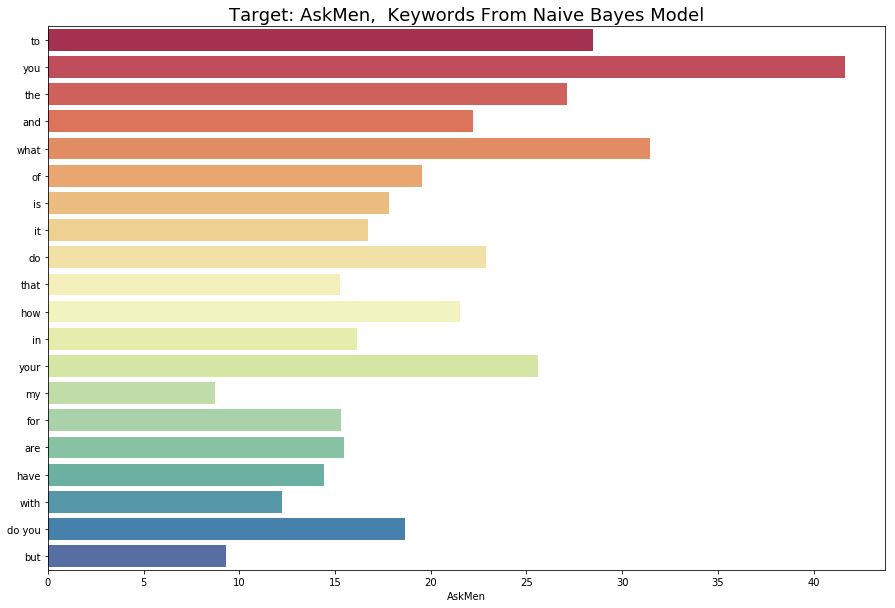

In [111]:
#plot counts 
plt.figure(figsize = (15,10))
plt.title('Target: AskMen,  Keywords From Naive Bayes Model', fontsize = 18)
sns.barplot(y = women_word.loc[nb_index,].index, 
            x = women_word.loc[nb_index,]['AskMen'],
            palette="Spectral")
plt.savefig('../images/AskMen_Keywords(NB).png')

In [112]:
#sort by coefficients from highest to lowest, for Logit
menwomen_word2.sort_values(by = 'logit_coef_switched', ascending = False).head(20)

,nb_coef_switched,logit_coef_switched
men,-5.973712,2.316345
guys,-6.145557,2.090470
my,-5.529801,1.924988
to,-4.810618,1.653101
and,-4.994186,1.596805
she,-6.118351,1.190787
her,-6.138620,1.107499
out,-6.014033,1.055357
men of,-6.776649,1.032370
that,-5.401980,0.946948


In [113]:
#extract index for sorted logistic regression
logreg_index = menwomen_word2.sort_values(by = 'logit_coef_switched', ascending = False).head(20).index

In [114]:
women_word.loc[logreg_index,]

,AskWomen,AskMen
men,3.661598,5.416497
guys,1.606848,5.827423
my,7.662634,8.725076
to,20.762132,28.453759
and,16.746842,22.188635
she,3.246631,4.119725
her,3.247596,4.102725
out,4.715427,6.896601
men of,1.003176,1.981658
that,11.003177,15.266470


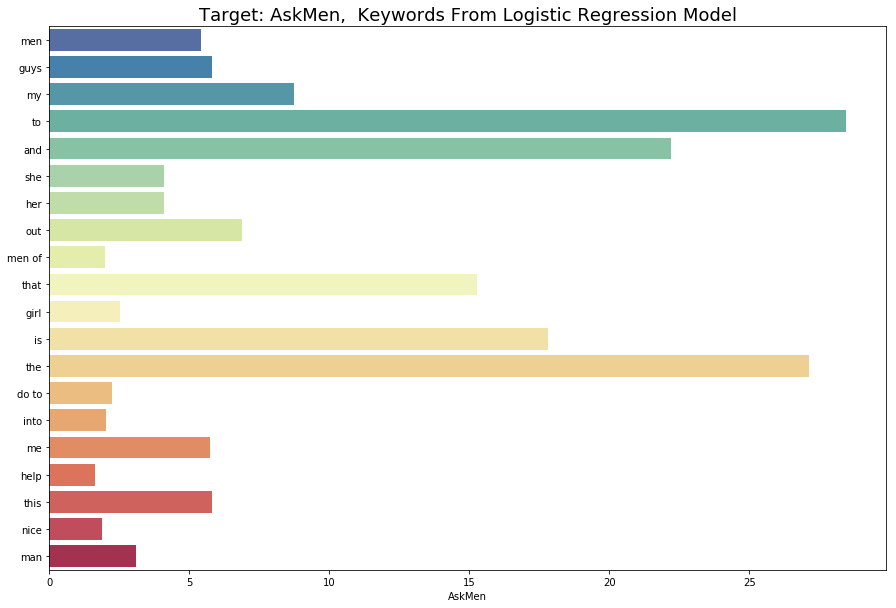

In [115]:
#plot counts 
plt.figure(figsize = (15,10))
plt.title('Target: AskMen,  Keywords From Logistic Regression Model', fontsize = 18)
sns.barplot(y = women_word.loc[logreg_index,].index, 
            x = women_word.loc[logreg_index,]['AskMen'],
            palette="Spectral_r")
plt.savefig('../images/AskMen_Keywords(logreg).png')